2024-01-22 12:01:04.654502: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-22 12:01:04.768650: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 12:01:04.768692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 12:01:04.770485: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 12:01:04.783825: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-22 12:01:04.785281: I tensorflow/core/platform/cpu_feature_guard.cc:1

(Running UniTVelo 0.2.5.2)
2024-01-22 12:01:13
Keeping at most 1000000 cells per cluster
Filtered out 9174 genes that are detected 10 counts (shared).


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Extracted 3000 highly variable genes.
Leiden clustering ...
         Falling back to preprocessing with `sc.pp.pca` and default params.


Global seed set to 0


Number of Leiden Clusters: 13
Maximal Number of Modules: 14


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.96it/s]
Computing total RNAvelocity ...


  0%|          | 0/2930 [00:00<?, ?cells/s]

# Cross-Boundary Direction Correctness (A->B)
{('nIPC', 'Neuroblast'): 0.7635350134740456, ('Neuroblast', 'Granule immature'): 0.6243857455958592, ('Granule immature', 'Granule mature'): 0.28579456997638536, ('Radial Glia-like', 'Astrocytes'): 0.0033048723341613964, ('OPC', 'OL'): 0.40455348718628603}
Total Mean: 0.4163147377133475
# In-cluster Coherence
{'Astrocytes': 0.92849046, 'Cajal Retzius': 0.6366027, 'Cck-Tox': 0.63510185, 'Endothelial': 0.61730134, 'GABA': 0.6287837, 'Granule immature': 0.74632597, 'Granule mature': 0.68230665, 'Microglia': 0.8521447, 'Mossy': 0.6919849, 'Neuroblast': 0.7779303, 'OL': 0.53476644, 'OPC': 0.79533654, 'Radial Glia-like': 0.9258108, 'nIPC': 0.5407525}
Total Mean: 0.71383136510849


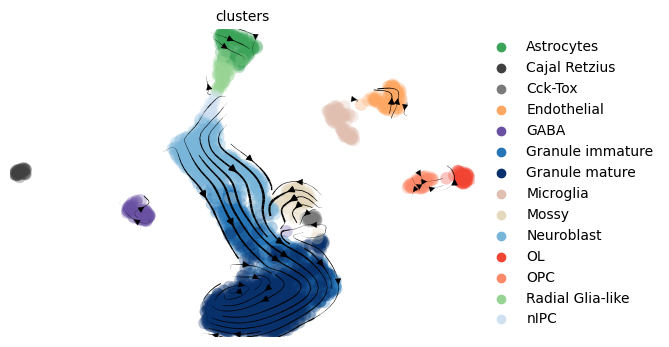

In [1]:
# import os
# os.chdir('..')
# os.chdir('..')
import scvelo as scv
import scanpy as sc
import scvi
import pickle as pickle
from eval_utils import cross_boundary_correctness
from datetime import datetime
import pandas as pd
import numpy as np
from os.path import exists
import matplotlib.pyplot as plt
import torch
import unitvelo as utv
import cell2fate as c2f
method = 'Cell2fateDynamicalModel_DentateGyrus_RobustnessAnalysis'
data_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/'
save_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_results/DentateGyrus_Robustness/'
dataset = 'DentateGyrus'
n_genes_array = np.array((1000, 2000, 3000, 4000, 5000))
min_counts = 10
Tmax_mean_array = np.array((12., 25., 50., 100., 200.))
Tmax_sd_array = np.array((12., 25., 50., 100., 200.))
module_multiplication = np.array((0.85, 1.0, 1.15, 1.3, 1.45))
seeds = np.array((0,1,2,3,4))

j = 0
i = 0
l = 2
k = 2
for j in range(len(Tmax_mean_array)):
    n_genes = n_genes_array[k]
    Tmax_mean = Tmax_mean_array[j]
    Tmax_sd = Tmax_sd_array[j]
    seed = seeds[i]
    module_factor = module_multiplication[l]
    save_name = method + '_Tmax_' + str(j)
    if exists(save_dir + save_name + '.pickle'):
        continue
    adata = sc.read_h5ad(data_dir + dataset + '/' + dataset + '_anndata.h5ad')
    adata = c2f.utils.get_training_data(adata, cells_per_cluster = 10**6, cluster_column = 'clusters',
                                    remove_clusters = [], min_shared_counts = min_counts, n_var_genes= n_genes)
    c2f.Cell2fate_DynamicalModel.setup_anndata(adata,
                                               spliced_label='spliced', unspliced_label='unspliced')    
    n_modules = int(np.round((c2f.utils.get_max_modules(adata)/1.15*module_factor)))
    mod = c2f.Cell2fate_DynamicalModel(adata,
                                       n_modules = n_modules,
                                      Tmax_prior={"mean": Tmax_mean, "sd": Tmax_sd})
    from cell2fate._pyro_mixin import PyroTrainingPlan_ClippedAdamDecayingRate
    scvi.settings.seed = seeds[i]
    mod.train(**{'training_plan' : PyroTrainingPlan_ClippedAdamDecayingRate})
    sample_kwarg = {"num_samples": 10, "batch_size" : adata.n_obs,
         "use_gpu" : True, 'return_samples': False}
    adata = mod.export_posterior(adata, sample_kwargs = sample_kwarg)
    post_sample_means = mod.samples['post_sample_means']
    post_sample_means['var_names'] = adata.var_names
    post_sample_means['obs_names'] = adata.obs_names
    post_sample_means['clusters'] = adata.obs['clusters']
    post_sample_means['ELBO'] = np.mean(np.array(mod.history['elbo_train'][-45:]))
    mod.compute_and_plot_total_velocity_scvelo(adata, save = save_dir + save_name + '.jpg', delete = False)
    # Calculate performance metrics:
    file = open(data_dir + dataset + '/' + dataset + '_groundTruth.pickle' ,'rb')
    ground_truth = pickle.load(file)
    metrics = utv.evaluate(adata, ground_truth, 'clusters', 'velocity')
    for x in metrics['Cross-Boundary Direction Correctness (A->B)'].keys():
        metrics['Cross-Boundary Direction Correctness (A->B)'][x] = np.mean(metrics['Cross-Boundary Direction Correctness (A->B)'][x])
    post_sample_means['CBDC'] = metrics['Cross-Boundary Direction Correctness (A->B)']
    with open(save_dir + save_name + '.pickle', 'wb') as handle:
        pickle.dump(post_sample_means, handle, protocol=pickle.HIGHEST_PROTOCOL)        

Keeping at most 1000000 cells per cluster
Filtered out 9174 genes that are detected 10 counts (shared).
Extracted 3000 highly variable genes.
Leiden clustering ...
         Falling back to preprocessing with `sc.pp.pca` and default params.


Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of Leiden Clusters: 13
Maximal Number of Modules: 14
Sampling global variables, sample: 100%|███████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.50it/s]
Computing total RNAvelocity ...


  0%|          | 0/2930 [00:00<?, ?cells/s]

# Cross-Boundary Direction Correctness (A->B)
{('nIPC', 'Neuroblast'): 0.5839197140977678, ('Neuroblast', 'Granule immature'): 0.5293888902436076, ('Granule immature', 'Granule mature'): 0.11765831610975498, ('Radial Glia-like', 'Astrocytes'): 0.4469468634627406, ('OPC', 'OL'): 0.983971555383923}
Total Mean: 0.5323770678595589
# In-cluster Coherence
{'Astrocytes': 0.7600885, 'Cajal Retzius': 0.6783456, 'Cck-Tox': 0.74905133, 'Endothelial': 0.5311761, 'GABA': 0.67818564, 'Granule immature': 0.57993317, 'Granule mature': 0.46567857, 'Microglia': 0.5830364, 'Mossy': 0.58989143, 'Neuroblast': 0.72169095, 'OL': 0.54235804, 'OPC': 0.1612418, 'Radial Glia-like': 0.61446357, 'nIPC': 0.65013975}
Total Mean: 0.5932344198226929


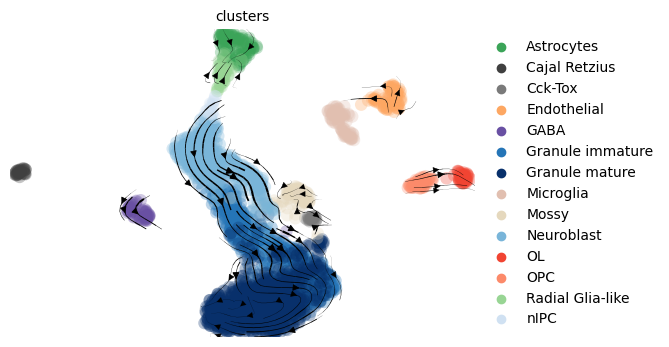

In [2]:
# import os
# os.chdir('..')
# os.chdir('..')
import scvelo as scv
import scanpy as sc
import scvi
import pickle as pickle
from eval_utils import cross_boundary_correctness
from datetime import datetime
import pandas as pd
import numpy as np
from os.path import exists
import matplotlib.pyplot as plt
import torch
import unitvelo as utv
import cell2fate as c2f
method = 'Cell2fateDynamicalModel_DentateGyrus_RobustnessAnalysis'
data_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/'
save_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_results/DentateGyrus_Robustness/'
dataset = 'DentateGyrus'
n_genes_array = np.array((1000, 2000, 3000, 4000, 5000))
min_counts = 10
Tmax_mean_array = np.array((50., 100., 200., 300., 500.))
Tmax_sd_array = np.array((50., 100., 100., 150., 150.))
module_multiplication = np.array((0.85, 1.0, 1.15, 1.3, 1.6))
seeds = np.array((0,1,2,3,4))

j = 0
i = 0
l = 2
k = 2
for l in range(4, len(module_multiplication)):
    n_genes = n_genes_array[k]
    Tmax_mean = Tmax_mean_array[j]
    Tmax_sd = Tmax_sd_array[j]
    seed = seeds[i]
    module_factor = module_multiplication[l]
    save_name = method + '_n_modules_' + str(l)
#     if exists(save_dir + save_name + '.pickle'):
#         continue
    adata = sc.read_h5ad(data_dir + dataset + '/' + dataset + '_anndata.h5ad')
    adata = c2f.utils.get_training_data(adata, cells_per_cluster = 10**6, cluster_column = 'clusters',
                                    remove_clusters = [], min_shared_counts = min_counts, n_var_genes= n_genes)
    c2f.Cell2fate_DynamicalModel.setup_anndata(adata,
                                               spliced_label='spliced', unspliced_label='unspliced')    
    n_modules = int(np.round((c2f.utils.get_max_modules(adata)/1.15*module_factor)))
    mod = c2f.Cell2fate_DynamicalModel(adata,
                                       n_modules = n_modules,
                                      Tmax_prior={"mean": Tmax_mean, "sd": Tmax_sd})
    from cell2fate._pyro_mixin import PyroTrainingPlan_ClippedAdamDecayingRate
    scvi.settings.seed = seeds[i]
    mod.train(**{'training_plan' : PyroTrainingPlan_ClippedAdamDecayingRate})
    sample_kwarg = {"num_samples": 10, "batch_size" : adata.n_obs,
         "use_gpu" : True, 'return_samples': False}
    adata = mod.export_posterior(adata, sample_kwargs = sample_kwarg)
    post_sample_means = mod.samples['post_sample_means']
    post_sample_means['var_names'] = adata.var_names
    post_sample_means['obs_names'] = adata.obs_names
    post_sample_means['clusters'] = adata.obs['clusters']
    post_sample_means['ELBO'] = np.mean(np.array(mod.history['elbo_train'][-45:]))
    mod.compute_and_plot_total_velocity_scvelo(adata, save = save_dir + save_name + '.jpg', delete = False)
    # Calculate performance metrics:
    file = open(data_dir + dataset + '/' + dataset + '_groundTruth.pickle' ,'rb')
    ground_truth = pickle.load(file)
    metrics = utv.evaluate(adata, ground_truth, 'clusters', 'velocity')
    for x in metrics['Cross-Boundary Direction Correctness (A->B)'].keys():
        metrics['Cross-Boundary Direction Correctness (A->B)'][x] = np.mean(metrics['Cross-Boundary Direction Correctness (A->B)'][x])
    post_sample_means['CBDC'] = metrics['Cross-Boundary Direction Correctness (A->B)']
    with open(save_dir + save_name + '.pickle', 'wb') as handle:
        pickle.dump(post_sample_means, handle, protocol=pickle.HIGHEST_PROTOCOL)        

In [ ]:
# import os
# os.chdir('..')
# os.chdir('..')
import scvelo as scv
import scanpy as sc
import scvi
import pickle as pickle
from eval_utils import cross_boundary_correctness
from datetime import datetime
import pandas as pd
import numpy as np
from os.path import exists
import matplotlib.pyplot as plt
import torch
import unitvelo as utv
import cell2fate as c2f
method = 'Cell2fateDynamicalModel_DentateGyrus_RobustnessAnalysis'
data_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/'
save_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_results/DentateGyrus_Robustness/'
dataset = 'DentateGyrus'
n_genes_array = np.array((1000, 2000, 3000, 4000, 5000))
min_counts = 10
Tmax_mean_array = np.array((50., 100., 200., 300., 500.))
Tmax_sd_array = np.array((50., 100., 100., 150., 150.))
module_multiplication = np.array((0.85, 1.0, 1.15, 1.3, 1.45))
seeds = np.array((0, 100, 200, 300, 400))

j = 0
i = 0
l = 2
k = 2
for i in range(1, len(seeds)):
    n_genes = n_genes_array[k]
    Tmax_mean = Tmax_mean_array[j]
    Tmax_sd = Tmax_sd_array[j]
    seed = seeds[i]
    module_factor = module_multiplication[l]
    save_name = method + '_seed_' + str(i)
#     if exists(save_dir + save_name + '.pickle'):
#         continue
    adata = sc.read_h5ad(data_dir + dataset + '/' + dataset + '_anndata.h5ad')
    adata = c2f.utils.get_training_data(adata, cells_per_cluster = 10**6, cluster_column = 'clusters',
                                    remove_clusters = [], min_shared_counts = min_counts, n_var_genes= n_genes)
    c2f.Cell2fate_DynamicalModel.setup_anndata(adata,
                                               spliced_label='spliced', unspliced_label='unspliced')    
    n_modules = int(np.round((c2f.utils.get_max_modules(adata)/1.15*module_factor)))
    mod = c2f.Cell2fate_DynamicalModel(adata,
                                       n_modules = n_modules,
                                      Tmax_prior={"mean": Tmax_mean, "sd": Tmax_sd})
    from cell2fate._pyro_mixin import PyroTrainingPlan_ClippedAdamDecayingRate
    scvi.settings.seed = seeds[i]
    mod.train(**{'training_plan' : PyroTrainingPlan_ClippedAdamDecayingRate})
    sample_kwarg = {"num_samples": 10, "batch_size" : adata.n_obs,
         "use_gpu" : True, 'return_samples': False}
    adata = mod.export_posterior(adata, sample_kwargs = sample_kwarg)
    post_sample_means = mod.samples['post_sample_means']
    post_sample_means['var_names'] = adata.var_names
    post_sample_means['obs_names'] = adata.obs_names
    post_sample_means['clusters'] = adata.obs['clusters']
    post_sample_means['ELBO'] = np.mean(np.array(mod.history['elbo_train'][-45:]))
    mod.compute_and_plot_total_velocity_scvelo(adata, save = save_dir + save_name + '.jpg', delete = False)
    # Calculate performance metrics:
    file = open(data_dir + dataset + '/' + dataset + '_groundTruth.pickle' ,'rb')
    ground_truth = pickle.load(file)
    metrics = utv.evaluate(adata, ground_truth, 'clusters', 'velocity')
    for x in metrics['Cross-Boundary Direction Correctness (A->B)'].keys():
        metrics['Cross-Boundary Direction Correctness (A->B)'][x] = np.mean(metrics['Cross-Boundary Direction Correctness (A->B)'][x])
    post_sample_means['CBDC'] = metrics['Cross-Boundary Direction Correctness (A->B)']
    with open(save_dir + save_name + '.pickle', 'wb') as handle:
        pickle.dump(post_sample_means, handle, protocol=pickle.HIGHEST_PROTOCOL)        

Keeping at most 1000000 cells per cluster
Filtered out 9174 genes that are detected 10 counts (shared).
Extracted 3000 highly variable genes.
Leiden clustering ...
         Falling back to preprocessing with `sc.pp.pca` and default params.


Global seed set to 100
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-cabed480-71db-8ae2-d02c-e01d42a2060d/5/0]


Number of Leiden Clusters: 13
Maximal Number of Modules: 14
Sampling global variables, sample: 100%|███████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.82it/s]
Computing total RNAvelocity ...


  0%|          | 0/2930 [00:00<?, ?cells/s]

# Cross-Boundary Direction Correctness (A->B)
{('nIPC', 'Neuroblast'): 0.5573639506062037, ('Neuroblast', 'Granule immature'): 0.5369535355273455, ('Granule immature', 'Granule mature'): 0.34549351948184365, ('Radial Glia-like', 'Astrocytes'): 0.7907756072678945, ('OPC', 'OL'): 0.17676815008802932}
Total Mean: 0.4814709525942633
# In-cluster Coherence
{'Astrocytes': 0.9724379, 'Cajal Retzius': 0.63016135, 'Cck-Tox': 0.7611049, 'Endothelial': 0.62314916, 'GABA': 0.42980137, 'Granule immature': 0.7531771, 'Granule mature': 0.65508497, 'Microglia': 0.79485375, 'Mossy': 0.6520067, 'Neuroblast': 0.7966224, 'OL': 0.69301116, 'OPC': 0.6262504, 'Radial Glia-like': 0.9289452, 'nIPC': 0.63293505}
Total Mean: 0.7106814980506897
Keeping at most 1000000 cells per cluster
Filtered out 9174 genes that are detected 10 counts (shared).
Extracted 3000 highly variable genes.
Leiden clustering ...
         Falling back to preprocessing with `sc.pp.pca` and default params.


Global seed set to 200
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-cabed480-71db-8ae2-d02c-e01d42a2060d/5/0]


Number of Leiden Clusters: 13
Maximal Number of Modules: 14
Epoch 146/500:  29%|█████████████████████▍                                                    | 145/500 [02:42<06:38,  1.12s/it, v_num=1, elbo_train=5.96e+6]

2024-02-05 16:38:48.917259: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-05 16:38:49.566609: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 16:38:49.566676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 16:38:49.723975: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-05 16:38:50.003396: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-05 16:38:50.006318: I tensorflow/core/platform/cpu_feature_guard.cc:1

(Running UniTVelo 0.2.5.2)
2024-02-05 16:39:01
4500
Keeping at most 1000000 cells per cluster
Filtered out 9174 genes that are detected 10 counts (shared).


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Extracted 4500 highly variable genes.
Leiden clustering ...
         Falling back to preprocessing with `sc.pp.pca` and default params.


Global seed set to 0


Number of Leiden Clusters: 14
Maximal Number of Modules: 16


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-cabed480-71db-8ae2-d02c-e01d42a2060d/5/0]


Sampling global variables, sample: 100%|███████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.76it/s]
Computing total RNAvelocity ...


  0%|          | 0/2930 [00:00<?, ?cells/s]

# Cross-Boundary Direction Correctness (A->B)
{('nIPC', 'Neuroblast'): 0.6522667125234282, ('Neuroblast', 'Granule immature'): 0.5740178401933498, ('Granule immature', 'Granule mature'): 0.3274120219393203, ('Radial Glia-like', 'Astrocytes'): 0.6655730695948054, ('OPC', 'OL'): 0.9381797065874121}
Total Mean: 0.6314898701676632
# In-cluster Coherence
{'Astrocytes': 0.8903416, 'Cajal Retzius': 0.742437, 'Cck-Tox': 0.71700436, 'Endothelial': 0.5807185, 'GABA': 0.81839883, 'Granule immature': 0.7180146, 'Granule mature': 0.68508565, 'Microglia': 0.5357732, 'Mossy': 0.68364394, 'Neuroblast': 0.7646986, 'OL': 0.6241092, 'OPC': 0.3979229, 'Radial Glia-like': 0.81834906, 'nIPC': 0.7175345}
Total Mean: 0.6924307942390442
6000
Keeping at most 1000000 cells per cluster
Filtered out 9174 genes that are detected 10 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Leiden clustering ...
         Falling back to preprocessing with `sc.pp.pca` and def

Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-cabed480-71db-8ae2-d02c-e01d42a2060d/5/0]


Number of Leiden Clusters: 15
Maximal Number of Modules: 17
Sampling global variables, sample: 100%|███████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.67it/s]
Computing total RNAvelocity ...


  0%|          | 0/2930 [00:00<?, ?cells/s]

# Cross-Boundary Direction Correctness (A->B)
{('nIPC', 'Neuroblast'): 0.5578717252317453, ('Neuroblast', 'Granule immature'): 0.5552551930569908, ('Granule immature', 'Granule mature'): 0.36244578479310435, ('Radial Glia-like', 'Astrocytes'): 0.6431201287703804, ('OPC', 'OL'): 0.45551555412093236}
Total Mean: 0.5148416771946306
# In-cluster Coherence
{'Astrocytes': 0.9376821, 'Cajal Retzius': 0.70493746, 'Cck-Tox': 0.67357075, 'Endothelial': 0.5335233, 'GABA': 0.7614563, 'Granule immature': 0.80845386, 'Granule mature': 0.7027092, 'Microglia': 0.64994675, 'Mossy': 0.6387303, 'Neuroblast': 0.71890795, 'OL': 0.90286237, 'OPC': 0.8819307, 'Radial Glia-like': 0.8024927, 'nIPC': 0.5257599}
Total Mean: 0.7316402196884155


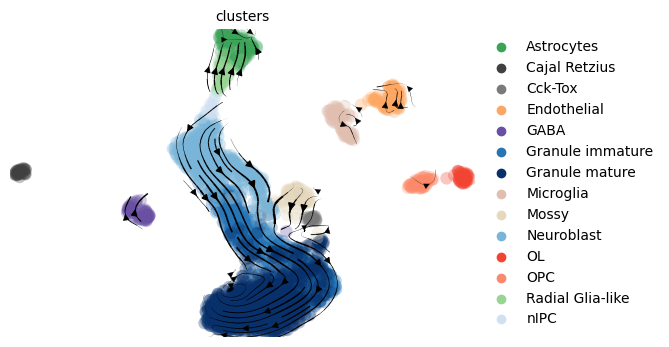

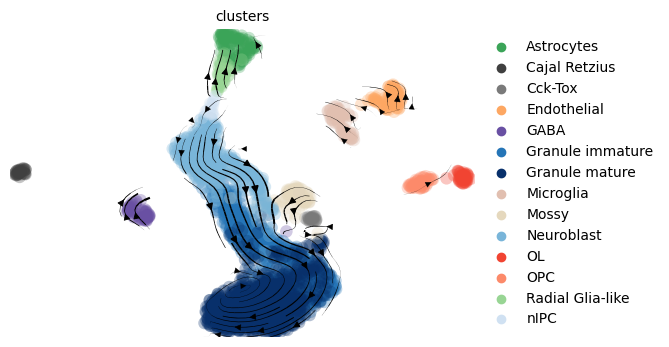

In [1]:
# import os
# os.chdir('..')
# os.chdir('..')
import scvelo as scv
import scanpy as sc
import scvi
import pickle as pickle
from eval_utils import cross_boundary_correctness
from datetime import datetime
import pandas as pd
import numpy as np
from os.path import exists
import matplotlib.pyplot as plt
import torch
import unitvelo as utv
import cell2fate as c2f
method = 'Cell2fateDynamicalModel_DentateGyrus_RobustnessAnalysis'
data_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/'
save_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_results/DentateGyrus_Robustness/'
dataset = 'DentateGyrus'
n_genes_array = np.array((1000, 2000, 3000, 4500, 6000))
min_counts = 10
Tmax_mean_array = np.array((50., 100., 200., 300., 500.))
Tmax_sd_array = np.array((50., 100., 100., 150., 150.))
module_multiplication = np.array((0.8, 1.0, 1.15, 1.3, 1.5))
seeds = np.array((0,1,2,3,4))

j = 0
i = 0
l = 2
for k in range(len(n_genes_array)):
    n_genes = n_genes_array[k]
    print(n_genes)
    Tmax_mean = Tmax_mean_array[j]
    Tmax_sd = Tmax_sd_array[j]
    seed = seeds[i]
    module_factor = module_multiplication[l]
    save_name = method + '_nGenes_' + str(k)
#     if exists(save_dir + save_name + '.pickle'):
#         continue
    adata = sc.read_h5ad(data_dir + dataset + '/' + dataset + '_anndata.h5ad')
    adata = c2f.utils.get_training_data(adata, cells_per_cluster = 10**6, cluster_column = 'clusters',
                                    remove_clusters = [], min_shared_counts = min_counts, n_var_genes= n_genes)
    c2f.Cell2fate_DynamicalModel.setup_anndata(adata,
                                               spliced_label='spliced', unspliced_label='unspliced')    
    n_modules = int(np.round((c2f.utils.get_max_modules(adata)/1.15*module_factor)))
    mod = c2f.Cell2fate_DynamicalModel(adata,
                                       n_modules = n_modules,
                                      Tmax_prior={"mean": Tmax_mean, "sd": Tmax_sd})
    from cell2fate._pyro_mixin import PyroTrainingPlan_ClippedAdamDecayingRate
    scvi.settings.seed = seeds[i]
    mod.train(**{'training_plan' : PyroTrainingPlan_ClippedAdamDecayingRate})
    sample_kwarg = {"num_samples": 10, "batch_size" : adata.n_obs,
         "use_gpu" : True, 'return_samples': False}
    adata = mod.export_posterior(adata, sample_kwargs = sample_kwarg)
    post_sample_means = mod.samples['post_sample_means']
    post_sample_means['var_names'] = adata.var_names
    post_sample_means['obs_names'] = adata.obs_names
    post_sample_means['clusters'] = adata.obs['clusters']
    post_sample_means['ELBO'] = np.mean(np.array(mod.history['elbo_train'][-45:]))
    mod.compute_and_plot_total_velocity_scvelo(adata, save = save_dir + save_name + '.jpg', delete = False)
    # Calculate performance metrics:
    file = open(data_dir + dataset + '/' + dataset + '_groundTruth.pickle' ,'rb')
    ground_truth = pickle.load(file)
    metrics = utv.evaluate(adata, ground_truth, 'clusters', 'velocity')
    for x in metrics['Cross-Boundary Direction Correctness (A->B)'].keys():
        metrics['Cross-Boundary Direction Correctness (A->B)'][x] = np.mean(metrics['Cross-Boundary Direction Correctness (A->B)'][x])
    post_sample_means['CBDC'] = metrics['Cross-Boundary Direction Correctness (A->B)']
    with open(save_dir + save_name + '.pickle', 'wb') as handle:
        pickle.dump(post_sample_means, handle, protocol=pickle.HIGHEST_PROTOCOL)        